In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras import Input, models, layers, optimizers, metrics
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.applications import VGG16
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

In [7]:
!git clone https://github.com/taehojo/data-ch20.git

Cloning into 'data-ch20'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (265/265), done.
remote: Total 265 (delta 0), reused 265 (delta 0), pack-reused 0
Receiving objects: 100% (265/265), 1.86 MiB | 25.42 MiB/s, done.


In [9]:
# 학습셋의 변형을 설정
train_datagen = ImageDataGenerator(rescale=1./255,          # 주어진 이미지의 크기를 설정합니다.
                                  horizontal_flip=True,     # 수평 대칭 이미지를 50% 확률로 만들어 추가합니다.
                                  width_shift_range=0.1,    # 전체 크기의 15% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1,   # 마찬가지로 위, 아래로 이동합니다.
                                  #rotation_range=5,        # 정해진 각도만큼 회전시킵니다.
                                  #shear_range=0.7,         # 좌표 하나를 고정시키고 나머지를 이동시킵니다.
                                  #zoom_range=1.2,          # 확대 또는 축소시킵니다.
                                  #vertical_flip=True,      # 수직 대칭 이미지를 만듭니다.
                                  #fill_mode='nearest'      # 빈 공간을 채우는 방법입니다. nearest 옵션은 가장 비슷한 색으로 채우게 됩니다.
                                  )      


train_generator = train_datagen.flow_from_directory(
       '/content/data-ch20/train',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

# 테스트셋의 정규화를 설정
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       '/content/data-ch20/test',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

# VGG16 모델 가져오기
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

# 우리의 모델을 설정
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 12

In [10]:
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

history = finetune_model.fit(
       train_generator,
       epochs=20,
       validation_data=test_generator,
       validation_steps=10, 
       callbacks=[early_stopping_callback])

Epoch 1/20
32/32 [==============================] - 50s 2s/step - loss: 0.6975 - accuracy: 0.5813 - val_loss: 0.5841 - val_accuracy: 0.7600
Epoch 2/20
32/32 [==============================] - 45s 1s/step - loss: 0.5352 - accuracy: 0.7250 - val_loss: 0.4530 - val_accuracy: 0.8600
Epoch 3/20
32/32 [==============================] - 45s 1s/step - loss: 0.4414 - accuracy: 0.8125 - val_loss: 0.3942 - val_accuracy: 0.8600
Epoch 4/20
32/32 [==============================] - 44s 1s/step - loss: 0.4448 - accuracy: 0.8188 - val_loss: 0.4036 - val_accuracy: 0.8600
Epoch 5/20
32/32 [==============================] - 45s 1s/step - loss: 0.4151 - accuracy: 0.8375 - val_loss: 0.3644 - val_accuracy: 0.9000
Epoch 6/20
32/32 [==============================] - 44s 1s/step - loss: 0.3138 - accuracy: 0.9000 - val_loss: 0.2868 - val_accuracy: 0.9200
Epoch 7/20
32/32 [==============================] - 45s 1s/step - loss: 0.2984 - accuracy: 0.9000 - val_loss: 0.2388 - val_accuracy: 0.9200
Epoch 8/20
32/32 [==

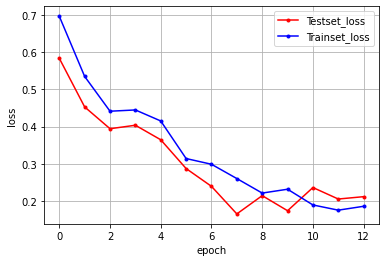

In [11]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Testset_loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Trainset_loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()